In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve
from scipy.ndimage.interpolation import shift

In [2]:
np.random.seed(3)

In [3]:
# Parameters
t = np.linspace(0,50,51)
D0 = 100
gamma = 0.1
sigma_eps = 3 #cash-flow shocks σε
T = 50
Q = 1
I = 50
X1 = 0.9 #p.207 footnote9
theta = 0.9
mu0 = 0.3 #fraction of fundamental invesetors
mu = [mu0] + [(1-mu0)/I]*I #list of fraction of investors
_w = 0.1
w = [[1] + [np.random.normal(_w, 0.03) for _ in range(I)]\
 for i in range(T)]

In [4]:
np.min(w)

0.004780530971878846

In [5]:
# Create Dt
e_D = [0]*11 + [2,6,12,18] + [18]*36
Dt = [i + D0 for i in e_D]
Dt = np.array(Dt)

In [6]:
fund_val = Dt - gamma*sigma_eps**2*(T-t)*Q

In [7]:
def binding_p(w_it, _x, _t, _Dt): #binding p for i at t
    return _Dt- gamma*sigma_eps**2*(T-_t-1)*Q + ((1-w_it)*_x/w_it)
def signal_x(lag_x, lag_p, lag2_p):
    return theta*lag_x + (1-theta)*(lag_p-lag2_p)
def demand_f(_Dt, _t, p):
    return (_Dt - gamma*sigma_eps**2*(T-_t-1)*Q - p)/(gamma*sigma_eps**2)
def demand_e(w_it, _Dt, _t, p, _x): #demand of i at t
    return w_it*(_Dt - gamma*sigma_eps**2*(T-_t-1)*Q \
                 - p)/(gamma*sigma_eps**2) + (1-w_it)*(_x/(gamma*sigma_eps**2))

In [8]:
def p_and_demands(_t, _x):
    bp_list = [binding_p(w_i, _x, _t, Dt[_t-1]) for w_i in w[_t-1]]
    bp_star = None
    min_diff = 10000
    N_list = []
    for bp in bp_list:
        demands = [demand_e(w_i, Dt[_t-1], _t, bp, _x) for w_i in w[_t-1]]
        N_bp = np.dot(mu, demands)#np.sum(demands)
        if N_bp > Q and min_diff > N_bp - Q:
            min_diff = N_bp - Q
            bp_star = bp
        N_list.append(N_bp)
    if bp_star != None:
        demands = [demand_e(w_i, Dt[_t-1], _t, bp_star, _x) for w_i in w[_t-1]]
        index = np.where(np.array(demands) > 0)[0]
        temp = np.dot(np.array(mu)[index], 1-np.array(w[_t-1])[index])
        temp1 = np.dot(np.array(mu)[index], np.array(w[_t-1])[index])
        p = Dt[_t-1] + (temp*_x)/(temp1) - gamma\
        *sigma_eps**2*Q*((temp1)*(T-_t-1)+1)/(temp1)
        demands = [np.max([demand_e(w_i, Dt[_t-1], _t, p, _x), 0]) for w_i in w[_t-1]]
    else:
        temp = np.dot(np.array(mu[1:]), 1-np.array(w[_t-1][1:]))
        temp1 = np.dot(np.array(mu[1:]), np.array(w[_t-1][1:]))
        p = Dt[_t-1] + (temp*_x)/(mu0 + temp1) - gamma\
        *sigma_eps**2*Q*((mu0 + temp1)*(T-_t-1)+1)/(mu0 + temp1)
        demands = [demand_e(w_i, Dt[_t-1], _t, p, _x) for w_i in w[_t-1]]

    return p, demands

In [9]:
#generate price, growth signal and demand 

p_list = [55] #start from p0
x_list = [0.9] #start from x1
d_list = []
for _t in t[1:]:
    #print(_t)
    p_list.append(p_and_demands(int(_t), x_list[-1])[0])
    d_list.append(p_and_demands(int(_t), x_list[-1])[1])
    x_list.append(signal_x(x_list[-1], p_list[-1], p_list[-2]))

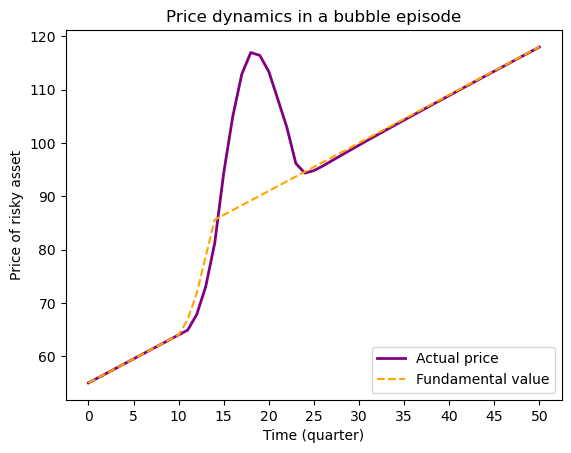

In [10]:
#price
plt.plot(t, p_list, label = "Actual price", color = 'purple', linewidth=2.0)
plt.plot(t, fund_val, label = "Fundamental value", linestyle="--", color = 'orange', linewidth=1.5)
plt.legend(loc='lower right')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.xlabel("Time (quarter)")
plt.ylabel("Price of risky asset")
plt.title('Price dynamics in a bubble episode')
plt.show()

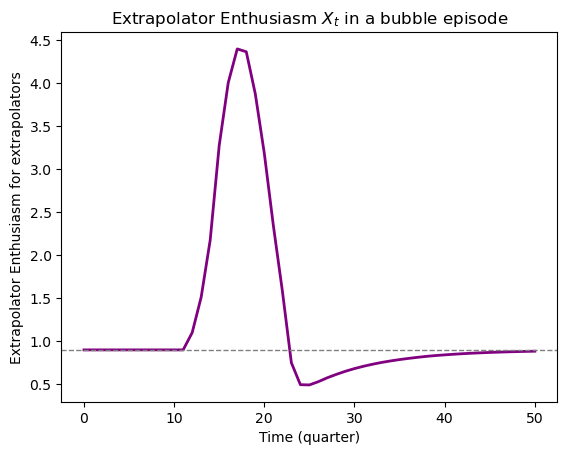

In [11]:
#growth signal
plt.plot(t, x_list, color = 'purple', linewidth=2.0)
plt.axhline(y = 0.9, color = 'grey', linestyle = '--', linewidth=1.0)
plt.xlabel("Time (quarter)")
plt.ylabel("Extrapolator Enthusiasm for extrapolators")
plt.title('Extrapolator Enthusiasm $X_t$ in a bubble episode')
plt.show()

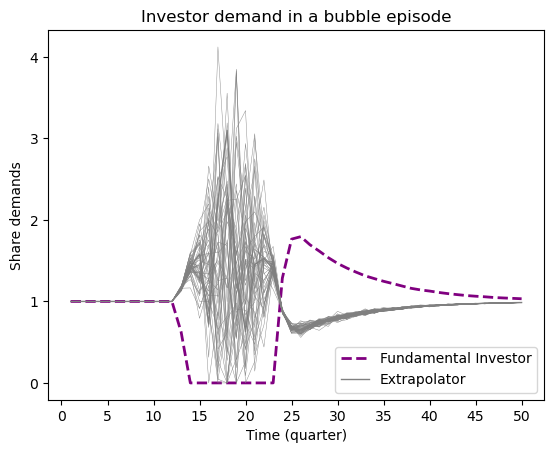

In [12]:
#Individual level investor demand
plt.plot(t[1:], np.array(d_list).T[0], label = "Fundamental Investor", color = 'purple', linestyle="--", linewidth=2.0)
plt.plot(t[1:], np.array(d_list).T[1], label = "Extrapolator", color = 'grey', linewidth=1.0)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='lower right')

for _i in range(2, I):
    plt.plot(t[1:], np.array(d_list).T[_i], color = 'gray', linewidth=0.3)
    
plt.xlabel("Time (quarter)")
plt.ylabel("Share demands")
plt.title('Investor demand in a bubble episode')
plt.show()

In [13]:
vol_list = []
for _i in range(I+1):
    vol_i = np.absolute(np.array(d_list).T[_i] - shift(np.array(d_list).T[_i], 
                                                       1, cval=np.NaN))
    vol_list.append(list(vol_i))

In [14]:
ttl_vol = []
for trades in list(np.array(vol_list).T):
    ttl_vol.append(0.5*(np.dot(mu, trades)))

In [15]:
exp_vol = []
for trades in list(np.array(vol_list).T):
    exp_vol.append(0.5*(np.dot(mu, trades)) - np.dot(mu[0],trades[0]))

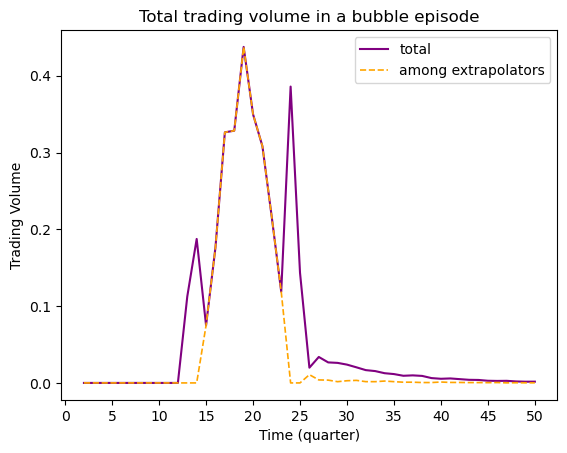

In [16]:
#Total trading volume
plt.plot(t[1:], ttl_vol, color = 'purple', label = 'total')
plt.plot(t[1:], exp_vol, color = 'orange', label = 'among extrapolators', 
         linestyle="--", linewidth=1.2)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='upper right')
plt.xlabel("Time (quarter)")
plt.ylabel("Trading Volume")
plt.title('Total trading volume in a bubble episode')
plt.show()

## Extension
### 1. Extrapolate on negative vs. positive price changes

In [17]:
#redefine X_t
theta_p = 0.9
theta_n = 0.86
def signal_x(lag_x, lag_p, lag2_p):
    change_p = lag_p - lag2_p
    if change_p > 0:#generate price, growth signal and demand
        return theta_p*lag_x + (1-theta_p)*(lag_p-lag2_p)
    else:
        return theta_n*lag_x + (1-theta_n)*(lag_p-lag2_p)

In [18]:
#regenerate price, growth signal and demand 

p_list_n = [55] #start from p0
x_list_n = [0.9] #start from x1
d_list_n = []
for _t in t[1:]:
    #print(_t)
    p_list_n.append(p_and_demands(int(_t), x_list_n[-1])[0])
    d_list_n.append(p_and_demands(int(_t), x_list_n[-1])[1])
    x_list_n.append(signal_x(x_list_n[-1], p_list_n[-1], p_list_n[-2]))

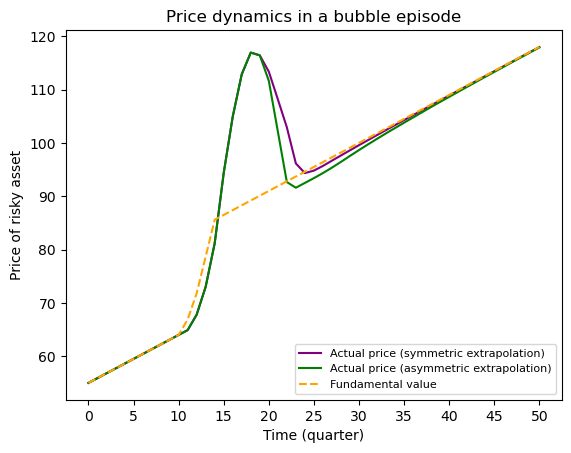

In [19]:
#price
plt.plot(t, p_list, label = "Actual price (symmetric extrapolation)", color = 'purple', linewidth=1.5)
plt.plot(t, p_list_n, label = "Actual price (asymmetric extrapolation)", color = 'green', linewidth=1.5)
plt.plot(t, fund_val, label = "Fundamental value", linestyle="--", color = 'orange', linewidth=1.5)
plt.legend(loc='lower right', fontsize = 8)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.xlabel("Time (quarter)")
plt.ylabel("Price of risky asset")
plt.title('Price dynamics in a bubble episode')
plt.show()

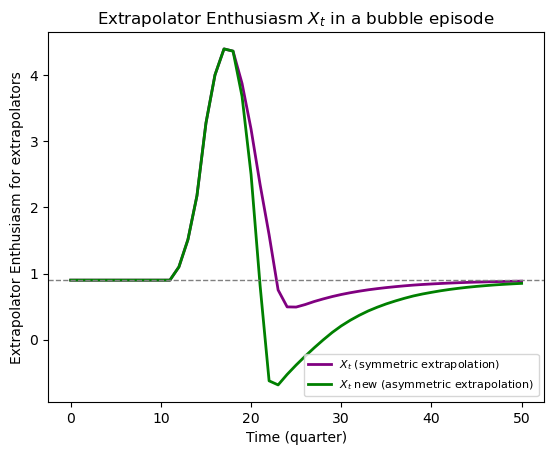

In [20]:
plt.plot(t, x_list, color = 'purple', label = "$X_t$ (symmetric extrapolation)", linewidth=2.0)
plt.plot(t, x_list_n, color = 'green', label = "$X_t$ new (asymmetric extrapolation)", linewidth=2.0)
plt.axhline(y = 0.9, color = 'grey', linestyle = '--', linewidth=1.0)
plt.xlabel("Time (quarter)")
plt.legend(loc='lower right', fontsize = 8)
plt.ylabel("Extrapolator Enthusiasm for extrapolators")
plt.title('Extrapolator Enthusiasm $X_t$ in a bubble episode')
plt.show()

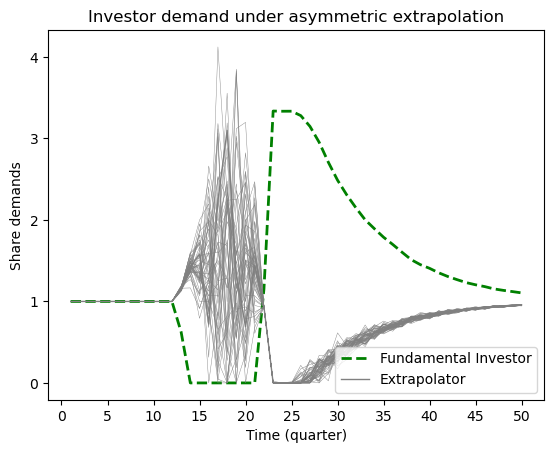

In [21]:
#Individual level investor demand
plt.plot(t[1:], np.array(d_list_n).T[0], label = "Fundamental Investor", color = 'green', linestyle="--", linewidth=2.0)
plt.plot(t[1:], np.array(d_list_n).T[1], label = "Extrapolator", color = 'grey', linewidth=1.0)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='lower right')

for _i in range(2, I):
    plt.plot(t[1:], np.array(d_list_n).T[_i], color = 'gray', linewidth=0.3)
    
plt.xlabel("Time (quarter)")
plt.ylabel("Share demands")
plt.title('Investor demand under asymmetric extrapolation')
plt.show()

In [22]:
vol_list = []
for _i in range(I+1):
    vol_i = np.absolute(np.array(d_list_n).T[_i] - shift(np.array(d_list_n).T[_i], 
                                                       1, cval=np.NaN))
    vol_list.append(list(vol_i))
ttl_vol_n = []
for trades in list(np.array(vol_list).T):
    ttl_vol_n.append(0.5*(np.dot(mu, trades)))
exp_vol_n = []
for trades in list(np.array(vol_list).T):
    exp_vol_n.append(0.5*(np.dot(mu, trades)) - np.dot(mu[0],trades[0]))

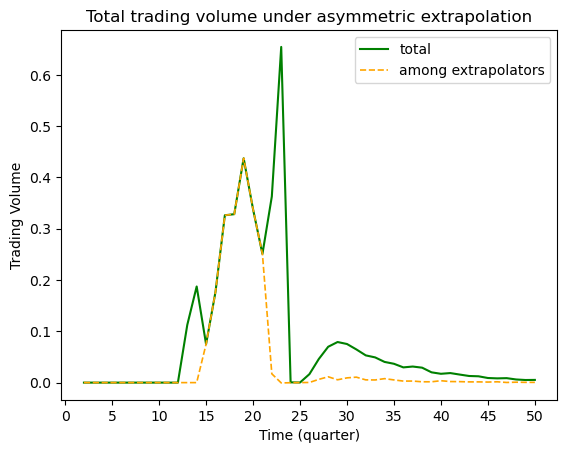

In [23]:
#Total trading volume
plt.plot(t[1:], ttl_vol_n, color = 'green', label = 'total')
plt.plot(t[1:], exp_vol_n, color = 'orange', label = 'among extrapolators', 
         linestyle="--", linewidth=1.2)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='upper right')
plt.xlabel("Time (quarter)")
plt.ylabel("Trading Volume")
plt.title('Total trading volume under asymmetric extrapolation')
plt.show()

### 2. Correlated wavering among extrapolators

In [24]:
cov_mat = []
for i in range(I):
    corr = [0.85*0.03*0.03 for _ in range(I)]
    corr[i] = 0.03*0.03
    cov_mat.append(corr)
np.array(cov_mat)

array([[0.0009  , 0.000765, 0.000765, ..., 0.000765, 0.000765, 0.000765],
       [0.000765, 0.0009  , 0.000765, ..., 0.000765, 0.000765, 0.000765],
       [0.000765, 0.000765, 0.0009  , ..., 0.000765, 0.000765, 0.000765],
       ...,
       [0.000765, 0.000765, 0.000765, ..., 0.0009  , 0.000765, 0.000765],
       [0.000765, 0.000765, 0.000765, ..., 0.000765, 0.0009  , 0.000765],
       [0.000765, 0.000765, 0.000765, ..., 0.000765, 0.000765, 0.0009  ]])

In [25]:
rng = np.random.default_rng()
y = rng.multivariate_normal([_w for _ in range(I)], cov_mat, size=T)

In [26]:
y

array([[0.07523058, 0.07598789, 0.07608368, ..., 0.05760353, 0.07811872,
        0.08982905],
       [0.06811717, 0.06091464, 0.07261066, ..., 0.06014746, 0.06476623,
        0.05614794],
       [0.12229825, 0.14613241, 0.13313292, ..., 0.14088739, 0.14342777,
        0.13600287],
       ...,
       [0.07212296, 0.06770307, 0.08362193, ..., 0.10320887, 0.08567918,
        0.06960513],
       [0.08386275, 0.05667544, 0.06255765, ..., 0.0872443 , 0.07846232,
        0.07441953],
       [0.05876176, 0.07618664, 0.06757936, ..., 0.08745132, 0.07259507,
        0.07869238]])

In [27]:
from scipy.stats import pearsonr
pearsonr(y[:, 2], y[:, 7]) #check

PearsonRResult(statistic=0.8404023869658742, pvalue=2.2991510712726763e-14)

In [28]:
#compute the new correlated weight list
w = []
for i in range(T):
    w.append([1]+list(y[:,i]))

In [29]:
#regenerate price, growth signal and demand 
def signal_x(lag_x, lag_p, lag2_p):
    return theta*lag_x + (1-theta)*(lag_p-lag2_p)
p_list_n = [55] #start from p0
x_list_n = [0.9] #start from x1
d_list_n = []
for _t in t[1:]:
    #print(_t)
    p_list_n.append(p_and_demands(int(_t), x_list_n[-1])[0])
    d_list_n.append(p_and_demands(int(_t), x_list_n[-1])[1])
    x_list_n.append(signal_x(x_list_n[-1], p_list_n[-1], p_list_n[-2]))

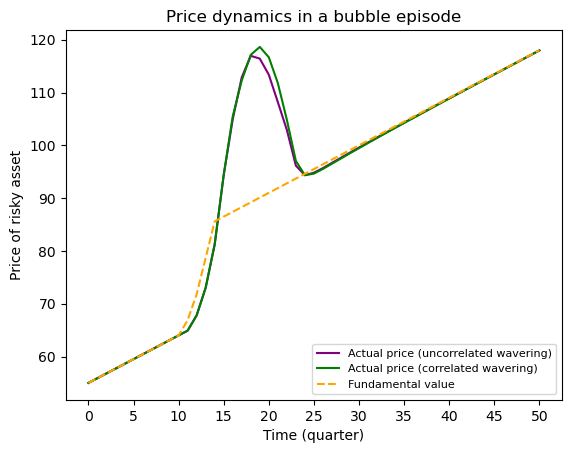

In [30]:
#price
plt.plot(t, p_list, label = "Actual price (uncorrelated wavering)", color = 'purple', linewidth=1.5)
plt.plot(t, p_list_n, label = "Actual price (correlated wavering)", color = 'green', linewidth=1.5)
plt.plot(t, fund_val, label = "Fundamental value", linestyle="--", color = 'orange', linewidth=1.5)
plt.legend(loc='lower right', fontsize = 8)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.xlabel("Time (quarter)")
plt.ylabel("Price of risky asset")
plt.title('Price dynamics in a bubble episode')
plt.show()

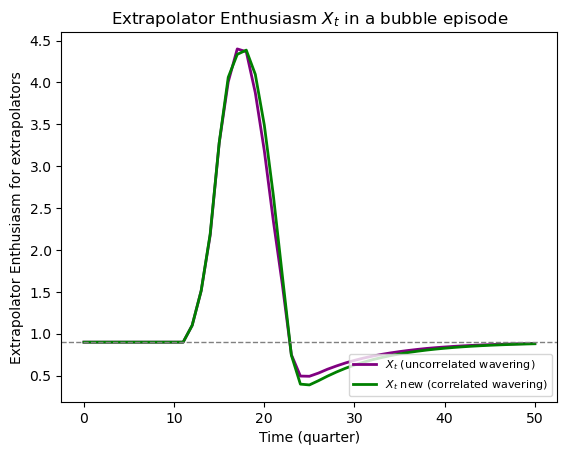

In [31]:
plt.plot(t, x_list, color = 'purple', label = "$X_t$ (uncorrelated wavering)", linewidth=2.0)
plt.plot(t, x_list_n, color = 'green', label = "$X_t$ new (correlated wavering)", linewidth=2.0)
plt.axhline(y = 0.9, color = 'grey', linestyle = '--', linewidth=1.0)
plt.xlabel("Time (quarter)")
plt.legend(loc='lower right', fontsize = 8)
plt.ylabel("Extrapolator Enthusiasm for extrapolators")
plt.title('Extrapolator Enthusiasm $X_t$ in a bubble episode')
plt.show()

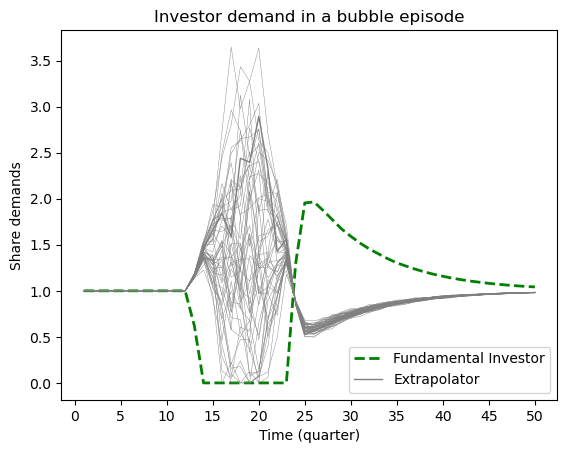

In [32]:
#Individual level investor demand
plt.plot(t[1:], np.array(d_list_n).T[0], label = "Fundamental Investor", color = 'green', linestyle="--", linewidth=2.0)
plt.plot(t[1:], np.array(d_list_n).T[1], label = "Extrapolator", color = 'grey', linewidth=1.0)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='lower right')

for _i in range(2, I):
    plt.plot(t[1:], np.array(d_list_n).T[_i], color = 'gray', linewidth=0.3)
    
plt.xlabel("Time (quarter)")
plt.ylabel("Share demands")
plt.title('Investor demand in a bubble episode')
plt.show()

In [33]:
vol_list = []
for _i in range(I+1):
    vol_i = np.absolute(np.array(d_list_n).T[_i] - shift(np.array(d_list_n).T[_i], 
                                                       1, cval=np.NaN))
    vol_list.append(list(vol_i))
ttl_vol_n = []
for trades in list(np.array(vol_list).T):
    ttl_vol_n.append(0.5*(np.dot(mu, trades)))
exp_vol_n = []
for trades in list(np.array(vol_list).T):
    exp_vol_n.append(0.5*(np.dot(mu, trades)) - np.dot(mu[0],trades[0]))

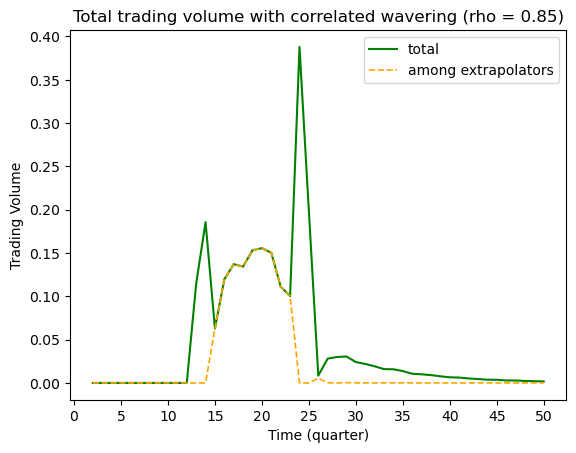

In [34]:
#Total trading volume
plt.plot(t[1:], ttl_vol_n, color = 'green', label = 'total')
plt.plot(t[1:], exp_vol_n, color = 'orange', label = 'among extrapolators', 
         linestyle="--", linewidth=1.2)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='upper right')
plt.xlabel("Time (quarter)")
plt.ylabel("Trading Volume")
plt.title('Total trading volume with correlated wavering (rho = 0.85)')
plt.show()

## 3. Composition of investors

In [35]:
#regenerate price, growth signal and demand 
w = [[1] + [np.random.normal(_w, 0.03) for _ in range(I)]\
 for i in range(T)]
p_list_n = [55] #start from p0
x_list_n = [0.9] #start from x1
d_list_n = []
mu0_list = []
for _t in t[1:]:
    mu0 = 0.3 - 0.03*(x_list_n[-1] - 0.9)#fraction of fundamental invesetors
    #print(mu0)
    mu = [mu0] + [(1-mu0)/I]*I
    mu0_list.append(mu0)
    #print(_t)
    p_list_n.append(p_and_demands(int(_t), x_list_n[-1])[0])
    d_list_n.append(p_and_demands(int(_t), x_list_n[-1])[1])
    x_list_n.append(signal_x(x_list_n[-1], p_list_n[-1], p_list_n[-2]))

Text(0.5, 1.0, 'Percentage of Extrapolators in a bubble episode')

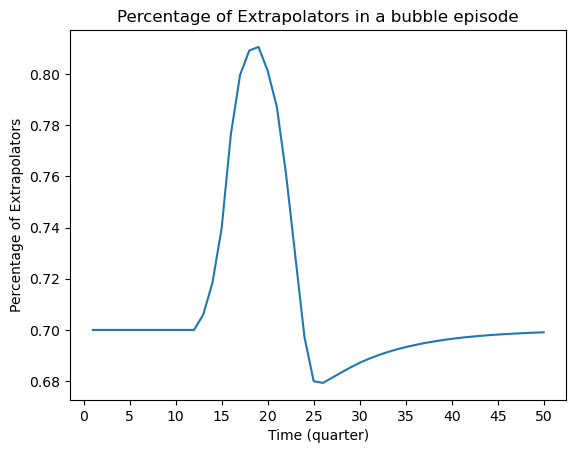

In [36]:
plt.plot(t[1:], [1-i for i in mu0_list])
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.xlabel("Time (quarter)")
plt.ylabel("Percentage of Extrapolators")
plt.title('Percentage of Extrapolators in a bubble episode')

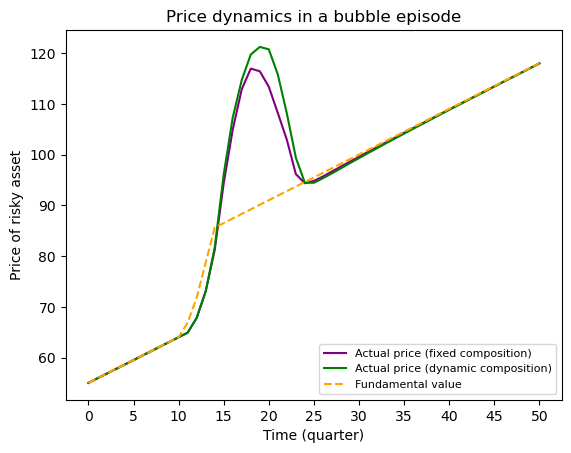

In [37]:
#price
plt.plot(t, p_list, label = "Actual price (fixed composition)", color = 'purple', linewidth=1.5)
plt.plot(t, p_list_n, label = "Actual price (dynamic composition)", color = 'green', linewidth=1.5)
plt.plot(t, fund_val, label = "Fundamental value", linestyle="--", color = 'orange', linewidth=1.5)
plt.legend(loc='lower right', fontsize = 8)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.xlabel("Time (quarter)")
plt.ylabel("Price of risky asset")
plt.title('Price dynamics in a bubble episode')
plt.show()

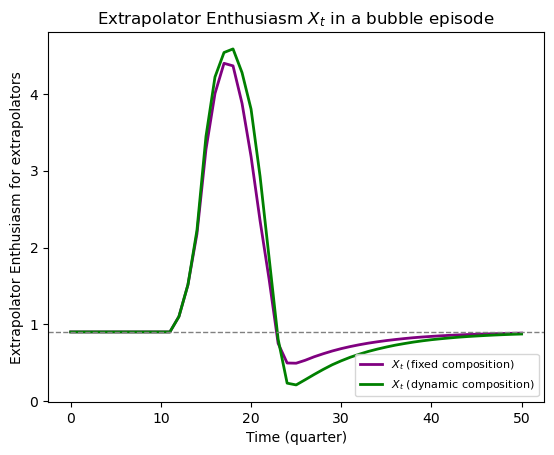

In [38]:
plt.plot(t, x_list, color = 'purple', label = "$X_t$ (fixed composition)", linewidth=2.0)
plt.plot(t, x_list_n, color = 'green', label = "$X_t$ (dynamic composition)", linewidth=2.0)
plt.axhline(y = 0.9, color = 'grey', linestyle = '--', linewidth=1.0)
plt.xlabel("Time (quarter)")
plt.legend(loc='lower right', fontsize = 8)
plt.ylabel("Extrapolator Enthusiasm for extrapolators")
plt.title('Extrapolator Enthusiasm $X_t$ in a bubble episode')
plt.show()

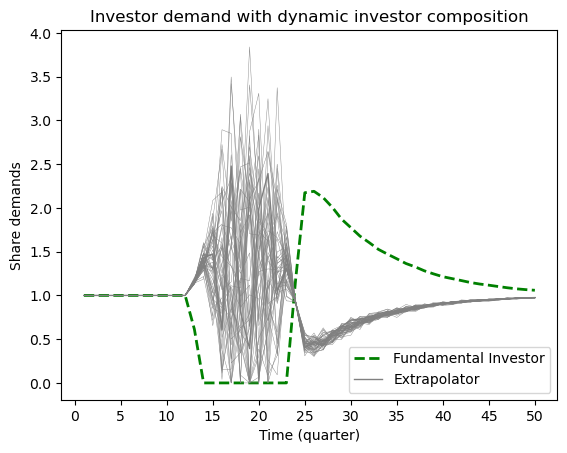

In [39]:
#Individual level investor demand
plt.plot(t[1:], np.array(d_list_n).T[0], label = "Fundamental Investor", color = 'green', linestyle="--", linewidth=2.0)
plt.plot(t[1:], np.array(d_list_n).T[1], label = "Extrapolator", color = 'grey', linewidth=1.0)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='lower right')

for _i in range(2, I):
    plt.plot(t[1:], np.array(d_list_n).T[_i], color = 'gray', linewidth=0.3)
    
plt.xlabel("Time (quarter)")
plt.ylabel("Share demands")
plt.title('Investor demand with dynamic investor composition')
plt.show()

In [40]:
vol_list = []
for _i in range(I+1):
    vol_i = np.absolute(np.array(d_list_n).T[_i] - shift(np.array(d_list_n).T[_i], 
                                                       1, cval=np.NaN))
    vol_list.append(list(vol_i))
ttl_vol_n = []
for trades in list(np.array(vol_list).T):
    ttl_vol_n.append(0.5*(np.dot(mu, trades)))
exp_vol_n = []
for trades in list(np.array(vol_list).T):
    exp_vol_n.append(0.5*(np.dot(mu, trades)) - np.dot(mu[0],trades[0]))

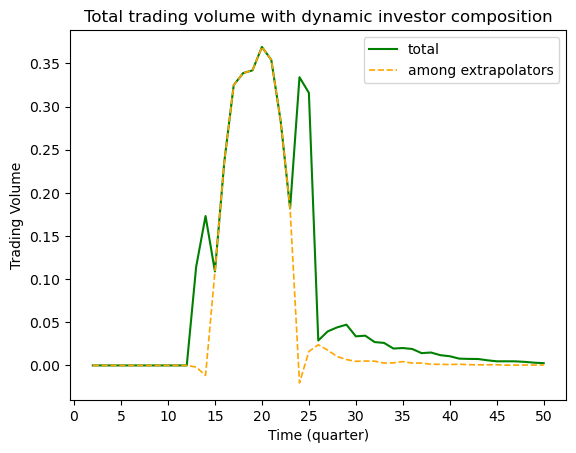

In [41]:
#Total trading volume
plt.plot(t[1:], ttl_vol_n, color = 'green', label = 'total')
plt.plot(t[1:], exp_vol_n, color = 'orange', label = 'among extrapolators', 
         linestyle="--", linewidth=1.2)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='upper right')
plt.xlabel("Time (quarter)")
plt.ylabel("Trading Volume")
plt.title('Total trading volume with dynamic investor composition')
plt.show()